In [1]:
from pipeline import *
from utils import *
%load_ext autoreload
%autoreload 2

## 1. Read raw datacube and remove background & fringe

In [3]:
raw_datacube = Read_Raw_SITELLE_datacube("/home/qliu/data/A2390F/A2390SEC4.fits",name="A2390E")
raw_datacube.header

SIMPLE  =                    T / Fits standard                                  
BITPIX  =                  -32 / Bits per pixel                                 
NAXIS   =                    3 / Number of axes                                 
NAXIS1  =                 2048 / Axis length                                    
NAXIS2  =                 2064 / Axis length                                    
NAXIS3  =                  150 / Axis length                                    
EXTEND  =                    T / File may contain extensions                    
ORIGIN  = 'NOAO-IRAF FITS Image Kernel July 2003' / FITS file originator        
IRAF-TLM= '2017-11-09T22:07:54' / Time of last modification                     
PROGRAM = 'ORB v3.1.2'         / Thomas Martin: thomas.martin.1@ulaval.ca       
DATE    = '2017-11-09T22:08:47' / Creation date                                 
MASK    = 'False   '                                                            
FILETYPE= 'Calibrated Spectr

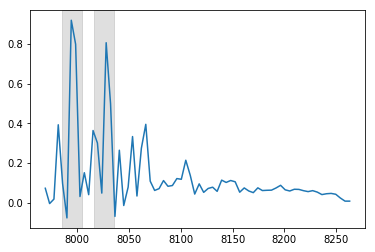

In [7]:
# med_stack = np.median(raw_datacube.raw_cube, axis=0)
spec_med = [np.median(raw_datacube.raw_cube[k]) for k in range(len(raw_datacube.wavl))]
plt.axvspan(7986,8006,color='gray',alpha=0.25)
plt.axvspan(8016,8036,color='gray',alpha=0.25)
plt.plot(raw_datacube.wavl, spec_med)

In [4]:
raw_datacube.save_mask_edge(save_path = './proc/A2390E/')

Remove 2D background channel by channel.

In [5]:
raw_datacube.remove_background(box_size=128, save_path='./A2390SE/fig_iso/bkg/128/', plot=False)

Removing background... Channel: 10
Removing background... Channel: 20
Removing background... Channel: 30
Removing background... Channel: 40
Removing background... Channel: 50
Removing background... Channel: 60


Check stack field. Note the strong fringe pattern.

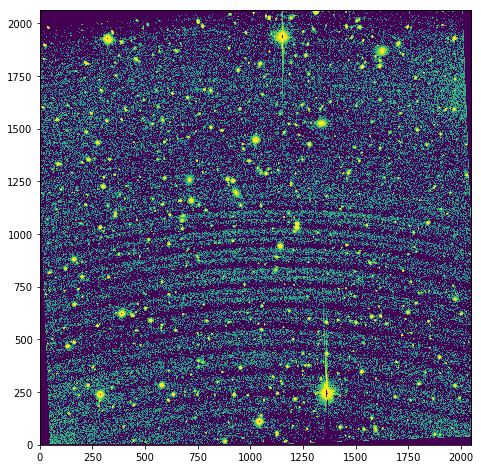

In [6]:
plt.figure(figsize=(8,8))
plt.imshow(raw_datacube.stack_field, norm=norm1, origin="lower", vmin=0, vmax=3)

Looking at some specific channels which suffer most. One choice is to not use / interpolate by nearby channels.

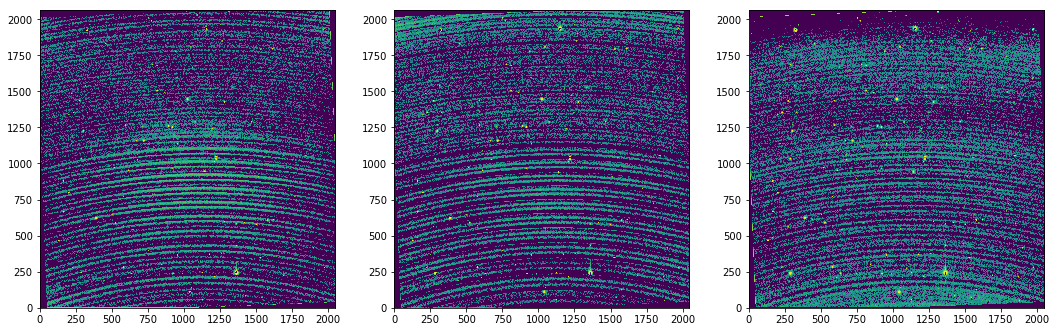

In [7]:
fig, axes = plt.subplots(1,3,figsize=(18,6))
for i, ax in zip([3,4,5], axes):
    ax.imshow(raw_datacube.datacube_bkg_sub[i], norm=norm1, origin="lower", vmin=0, vmax=1)

Interpolate from adjacent channels to reduce fringe effects in later on detection.

In [41]:
bad_channel = raw_datacube.interp_bad_channel(wavl_intp_range=[[7990,8000],[8022,8032]], interp=False)

Interpolate bad channels: 4, 5


Looking at one spaxel before and after interpolation:

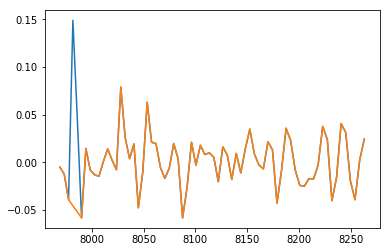

In [28]:
plt.plot(raw_datacube.wavl, raw_datacube.datacube_bkg_sub[:, 1000,800])
plt.plot(raw_datacube.wavl, raw_datacube.cube_process[:, 1000,800])
plt.axvspan(7986,8006,color='gray',alpha=0.25)
plt.axvspan(8016,8036,color='gray',alpha=0.25)

In [48]:
bad_channel = raw_datacube.get_channel([[7986,8006],[8016,8036]])
raw_datacube.remove_fringe(bad_channel, sn_source=5, save_path='./A2390SE/fig_iso/bkg/128/', plot=True)

Removing fringe... Channel: 0
Removing fringe... Channel: 1
Removing fringe... Channel: 2
Removing fringe... Channel: 3
Removing fringe... Channel: 4
Removing fringe... Channel: 5
Removing fringe... Channel: 6
Removing fringe... Channel: 7
Removing fringe... Channel: 8
Removing fringe... Channel: 9
Removing fringe... Channel: 10
Removing fringe... Channel: 11
Removing fringe... Channel: 12
Removing fringe... Channel: 13
Removing fringe... Channel: 14
Removing fringe... Channel: 15
Removing fringe... Channel: 16
Removing fringe... Channel: 17
Removing fringe... Channel: 18
Removing fringe... Channel: 19
Removing fringe... Channel: 20
Removing fringe... Channel: 21
Removing fringe... Channel: 22
Removing fringe... Channel: 23
Removing fringe... Channel: 24
Removing fringe... Channel: 25
Removing fringe... Channel: 26
Removing fringe... Channel: 27
Removing fringe... Channel: 28
Removing fringe... Channel: 29
Removing fringe... Channel: 30
Removing fringe... Channel: 31
Removing fringe...

After fringe subtraction:

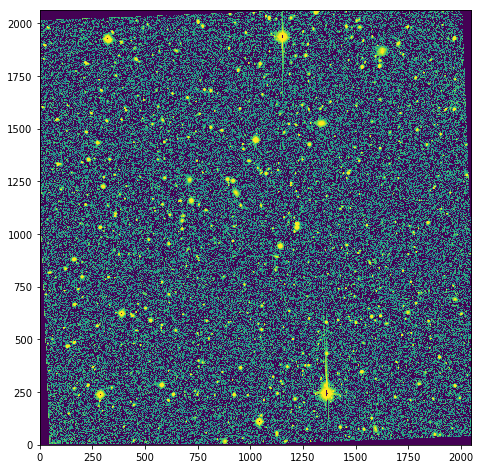

In [49]:
plt.figure(figsize=(8,8))
plt.imshow(raw_datacube.stack_field, norm=norm1, origin="lower", vmin=0, vmax=3)

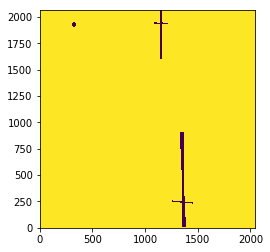

In [50]:
raw_datacube.save_weight_map(region_path="./A2390SE/A2390SE.reg", weight=0.001, save_path = './proc/A2390E/')
plt.imshow(raw_datacube.weight_map)

In [51]:
raw_datacube.save_fits(save_path = './proc/A2390E/', suffix="")

Saving background & fringe subtracted datacube and stacked field...


## 2. Extract source and spectra from datacube 

In [29]:
from pipeline import *
from utils import *

In [52]:
datacube = Read_Datacube('./proc/A2390E/A2390E_cube.fits', z0=0.228, name='A2390E', 
                         mask_edge='./proc/A2390E/Raw_stack_A2390E_mask.fits', mode="MMA")

In [53]:
src_map, segm, seg_map = datacube.ISO_source_detection(sn_thre=2.5, nlevels=64, contrast=0.01, box=(3,3,3),
                                                       closing=True, save=True, save_path = './proc/A2390E/', suffix="")

Use the map of maximum of moving average (MMA) to detect source.
Box shape:  (3, 3, 3)
Detecting and deblending source...


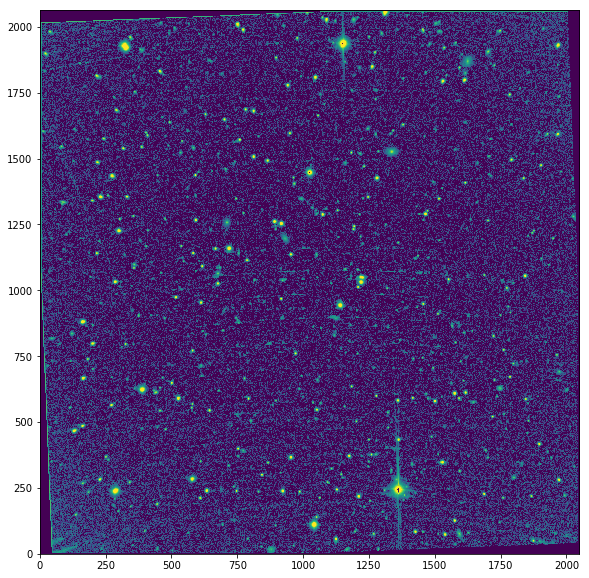

In [54]:
plt.figure(figsize=(10,10))
plt.imshow(datacube.src_map, norm=norm1, origin="lower", vmin=np.median(datacube.src_map), vmax=1)

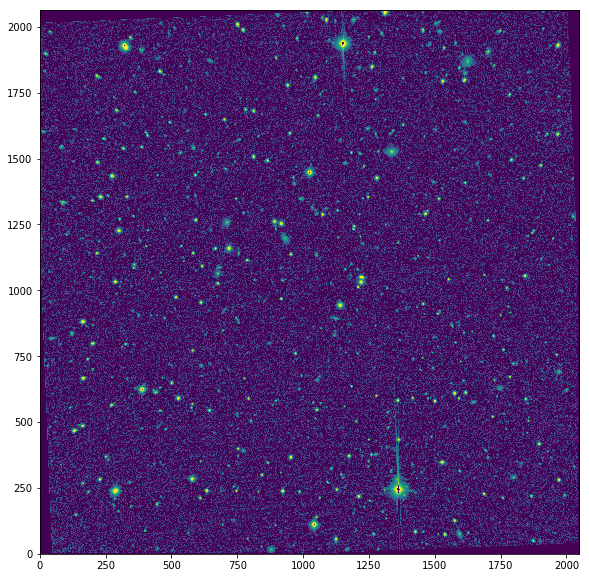

In [55]:
plt.figure(figsize=(10,10))
plt.imshow(datacube.stack_field, norm=norm1, origin="lower", vmin=np.median(datacube.src_map), vmax=60)

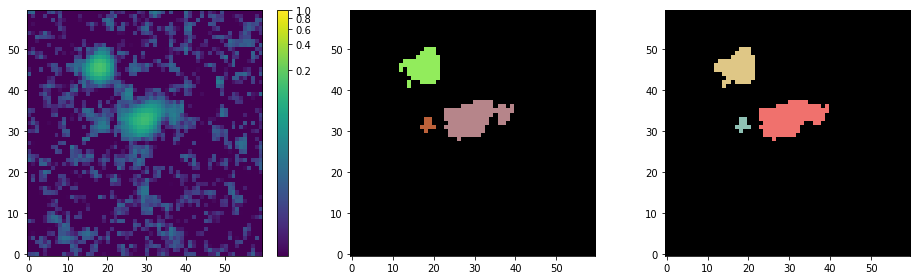

In [58]:
fig, (ax1,ax2,ax3) = plt.subplots(nrows=1,ncols=3,figsize=(13,4))
im1 = ax1.imshow(src_map[800:860,600:660], norm=norm1, aspect="auto",origin="lower", vmin=np.median(src_map), vmax=1)
colorbar(im1)   
im2 = ax2.imshow(segm.data[800:860,600:660], origin="lower", cmap=segm.make_cmap())
im3 = ax3.imshow(seg_map[800:860,600:660], origin="lower", cmap=segm.make_cmap()) 
plt.tight_layout()

In [57]:
datacube.ISO_spec_extraction_all(seg_map)

Extract spectra... 400/3929
Extract spectra... 800/3929
Extract spectra... 1200/3929
Extract spectra... 1600/3929
Extract spectra... 2000/3929
Extract spectra... 2400/3929
Extract spectra... 2800/3929
Extract spectra... 3200/3929
Extract spectra... 3600/3929


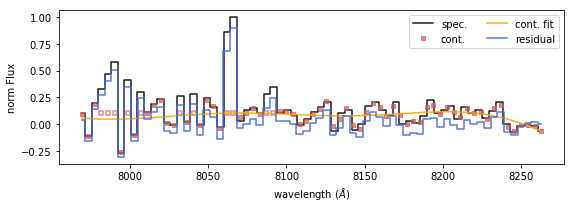

In [60]:
res, wavl_rebin, cont_fit = fit_continuum(datacube.obj_specs_opt[1486], datacube.wavl, edge_ratio=0.1)

In [61]:
datacube.fit_continuum_all(model='GP', plot=True, save_path='./A2390SE/fig_iso/fit_cont_MMA/')

./A2390SE/fig_iso/fit_cont_MMA/ does not exist. Make a new directory.
Fit continuum with GP. No edge_ratio is given. Use estimate = 0.05
Fit spectra continuum ... 200/3929
Fit spectra continuum ... 400/3929
Fit spectra continuum ... 600/3929
Fit spectra continuum ... 800/3929
Fit spectra continuum ... 1000/3929
Fit spectra continuum ... 1200/3929
Fit spectra continuum ... 1400/3929
Fit spectra continuum ... 1600/3929
Fit spectra continuum ... 1800/3929
Fit spectra continuum ... 2000/3929
Fit spectra continuum ... 2200/3929
Fit spectra continuum ... 2400/3929
Fit spectra continuum ... 2600/3929
Fit spectra continuum ... 2800/3929
Fit spectra continuum ... 3000/3929
Fit spectra continuum ... 3200/3929
Fit spectra continuum ... 3400/3929
Fit spectra continuum ... 3600/3929
Fit spectra continuum ... 3800/3929
Skip spurious detection:  #3383 #3395 #3402 #3411 #3427 #3430 #3435 #3447 #3448 #3456 #3458 #3460 #3688 #3793 #3794  ... Replaced with random noise.
Continuum Fitting Finished!


In [62]:
datacube.save_spec_fits(save_path='./proc/A2390E', suffix="_all")

### Comparison

In [5]:
hdu_spec = fits.open('./A2390SE/A2390SE-spec_v3.fits')
obj_nums = hdu_spec[0].data
obj_specs_opt = hdu_spec[3].data
wavl_rebin = hdu_spec[6].data

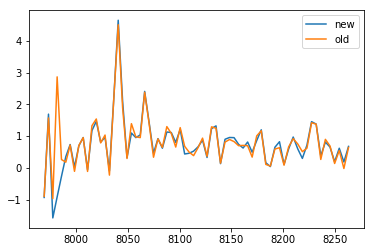

In [24]:
plt.plot(datacube.wavl, datacube.obj_specs_opt[808],label="new")
plt.plot(datacube.wavl, obj_specs_opt[348],label="old")
plt.legend()

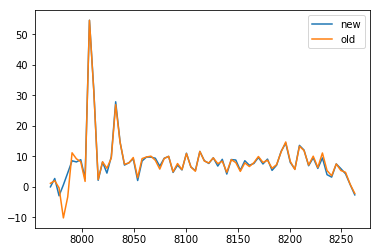

In [23]:
plt.plot(datacube.wavl, datacube.obj_specs_opt[1136],label="new")
plt.plot(datacube.wavl, obj_specs_opt[519],label="old")
plt.legend()

## 3. Generate Templates

In [1]:
from pipeline import *
from utils import *

In [2]:
datacube = Read_Datacube('./proc/A2390E/A2390E_cube.fits', 
                         name='A2390E', z0=0.228, mode="MMA",
                         table='./proc/A2390E/A2390E_MMA.dat', 
                         seg_map='./proc/A2390E/A2390E_segm_MMA.fits')

In [3]:
datacube.generate_template(n_ratio=1, n_stddev=10, n_intp=2, 
                           temp_type="OII", ratio_prior="log-uniform", temp_model='gauss')
datacube.generate_template(n_ratio=8, n_stddev=10, n_intp=2, ratio_range = (2., 4.), 
                           temp_type="Hb-OIII", ratio_prior="log-uniform", temp_model='gauss')
datacube.generate_template(n_ratio=40, n_stddev=10, n_intp=2, ratio_range = (1., 8),
                           temp_type="Ha-NII", ratio_prior="log-uniform", temp_model='gauss')

Template: OII_gauss  Total Number: 10
Template: Hb-OIII_gauss  Total Number: 80
Template: Ha-NII_gauss  Total Number: 400


In [4]:
datacube.generate_template(n_ratio=1, n_stddev=10, n_intp=2,
                           temp_type="OII", ratio_prior="log-uniform", temp_model='box')
datacube.generate_template(n_ratio=8, n_stddev=10, n_intp=2, ratio_range = (2., 4.),
                           temp_type="Hb-OIII", ratio_prior="log-uniform", temp_model='box')
datacube.generate_template(n_ratio=40, n_stddev=10, n_intp=2, ratio_range = (1., 8), 
                           temp_type="Ha-NII", ratio_prior="log-uniform", temp_model='box')

Template: OII_box  Total Number: 1
Template: Hb-OIII_box  Total Number: 8
Template: Ha-NII_box  Total Number: 40


In [5]:
for mod in ['gauss','box']:
    for typ in ["Ha-NII", "Hb-OIII", "OII"]:
        datacube.Save_Template(save_path='./proc/template/', temp_type=typ, temp_model=mod)

Save A2390E templates for Ha-NII_gauss as Template-A2390E_Ha-NII_gauss.fits
Save A2390E templates for Hb-OIII_gauss as Template-A2390E_Hb-OIII_gauss.fits
Save A2390E templates for OII_gauss as Template-A2390E_OII_gauss.fits
Save A2390E templates for Ha-NII_box as Template-A2390E_Ha-NII_box.fits
Save A2390E templates for Hb-OIII_box as Template-A2390E_Hb-OIII_box.fits
Save A2390E templates for OII_box as Template-A2390E_OII_box.fits


## 4. Cross-correlation

In [1]:
from pipeline import *
from utils import *
%load_ext autoreload
%autoreload 2

In [2]:
datacube = Read_Datacube('./proc/A2390E/A2390E_cube.fits', 
                         name='A2390E', z0=0.228, mode="MMA",
                         table='./proc/A2390E/A2390E_MMA.dat', 
                         seg_map='./proc/A2390E/A2390E_segm_MMA.fits')

datacube.read_spec('./proc/A2390E/A2390E-spec-MMA_all.fits')
datacube.Read_Template('./proc/template/', n_intp=2, name='A2390E')

Read Emission Line Template:
['./proc/template/Template-A2390E_Ha-NII_gauss.fits',
 './proc/template/Template-A2390E_Hb-OIII_gauss.fits',
 './proc/template/Template-A2390E_OII_gauss.fits',
 './proc/template/Template-A2390E_Ha-NII_box.fits',
 './proc/template/Template-A2390E_Hb-OIII_box.fits',
 './proc/template/Template-A2390E_OII_box.fits']


Detection #1137  z: 0.220  sigma: 2.688  Peak R: 2.873  Detction S/N: 31.688 Peak S/N: 14.572


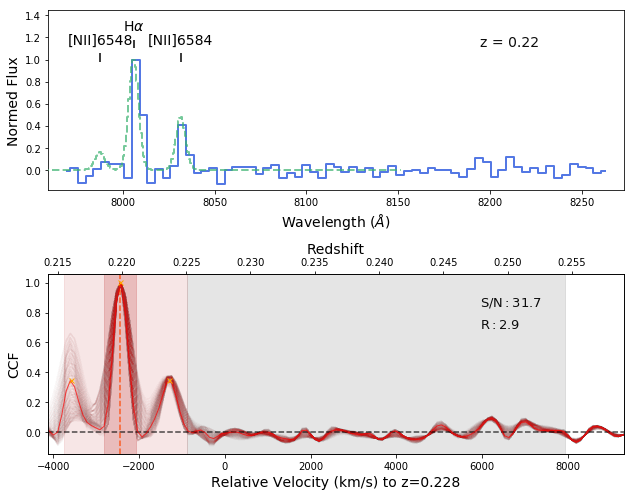

In [3]:
result = datacube.cross_correlation(1137, temp_type="Ha-NII", edge=20, const_window=False, temp_model="gauss")

Detection #809  z: 0.225  sigma: 3.115  Peak R: 2.346  Detction S/N: 13.809 Peak S/N: 8.672


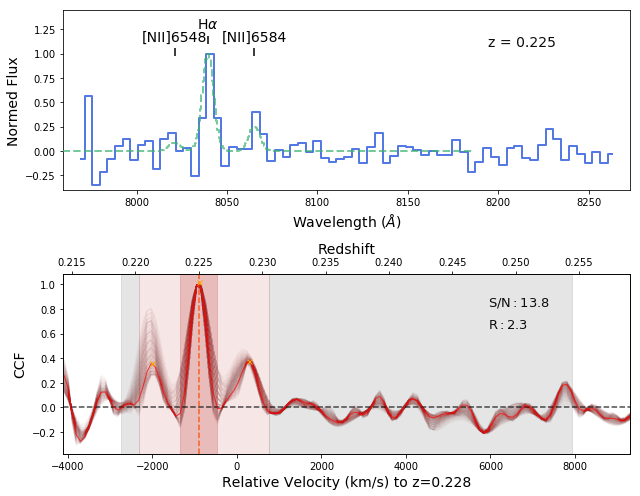

In [4]:
result = datacube.cross_correlation(809, temp_type="Ha-NII", edge=20, temp_model="gauss")

In [5]:
datacube.cross_correlation_all(temp_type="Ha-NII", temp_model="gauss", edge=20, verbose=False)
datacube.cross_correlation_all(temp_type="Hb-OIII", temp_model="gauss", edge=20, verbose=False)
datacube.cross_correlation_all(temp_type="OII", temp_model="gauss", edge=20, verbose=False)

Do cross-correlation using Ha-NII_gauss model templates...
Do cross-correlation using Hb-OIII_gauss model templates...
Do cross-correlation using OII_gauss model templates...


In [6]:
datacube.cross_correlation_all(temp_type="Ha-NII", temp_model="box", edge=20, verbose=False)
datacube.cross_correlation_all(temp_type="Hb-OIII", temp_model="box", edge=20, verbose=False)
datacube.cross_correlation_all(temp_type="OII", temp_model="box", edge=20, verbose=False)

Do cross-correlation using Ha-NII_box model templates...
Do cross-correlation using Hb-OIII_box model templates...
Do cross-correlation using OII_box model templates...


In [7]:
datacube.save_cc_result(save_path='./proc/A2390E/')

Save cross-correlation results for A2390E as : ./proc/A2390E/A2390E-cc.pkl
Template used: ['Ha-NII_gauss', 'Hb-OIII_gauss', 'OII_gauss', 'Ha-NII_box', 'Hb-OIII_box', 'OII_box']


## 5. Select Candidate

In [1]:
from pipeline import *
from utils import *
%load_ext autoreload
%autoreload 2

In [2]:
datacube = Read_Datacube('./proc/A2390E/A2390E_cube.fits', 
                         name='A2390E', z0=0.228, mode="MMA",
                         table='./proc/A2390E/A2390E_MMA.dat', 
                         seg_map='./proc/A2390E/A2390E_segm_MMA.fits',
                         mask_edge='./proc/A2390E/Raw_stack_A2390E_mask.fits')

datacube.deep_frame =  fits.open('./proc/A2390E/A2390E_DF.fits')[0].data
datacube.src_map = fits.open('./proc/A2390E/A2390E_MMA.fits')[0].data
datacube.read_spec('./proc/A2390E/A2390E-spec-MMA_all.fits')
datacube.Read_Template('./proc/template//', n_intp=2, name='A2390E')
datacube.read_cc_result('./proc/A2390E/A2390E-cc.pkl')

Read Emission Line Template:
['./proc/template/Template-A2390E_Ha-NII_gauss.fits',
 './proc/template/Template-A2390E_Hb-OIII_gauss.fits',
 './proc/template/Template-A2390E_OII_gauss.fits',
 './proc/template/Template-A2390E_Ha-NII_box.fits',
 './proc/template/Template-A2390E_Hb-OIII_box.fits',
 './proc/template/Template-A2390E_OII_box.fits']
Read cross-correlation results for A2390E from : ./proc/A2390E/A2390E-cc.pkl
Template used: ['Ha-NII_gauss', 'Hb-OIII_gauss', 'OII_gauss', 'Ha-NII_box', 'Hb-OIII_box', 'OII_box']


In [3]:
SNR_best_Ha_gauss = datacube.get_CC_result_best('SNR', 'Ha-NII_gauss')
SNR_best_OIII_gauss = datacube.get_CC_result_best('SNR', 'Hb-OIII_gauss')
SNR_best_OII_gauss = datacube.get_CC_result_best('SNR', 'OII_gauss')

SNR_best_Ha_box = datacube.get_CC_result_best('SNR', 'Ha-NII_box')
SNR_best_OII_box = datacube.get_CC_result_best('SNR', 'OII_box')

z_best_OIII_gauss = datacube.get_CC_result_best('z_best', 'Hb-OIII_gauss')
flag_e_Ha_gauss = datacube.get_CC_result_best('flag_e', 'Ha-NII_gauss')


### Match with SDSS stars

In [4]:
cat_match = datacube.match_sdss_star(sep=3*u.arcsec, search_radius=7*u.arcmin, band='rmag')

c_match_star = SkyCoord(ra=cat_match["RA_ICRS"], dec=cat_match["DE_ICRS"])
star_match_pos = np.array(c_match_star.to_pixel(datacube.wcs, origin=0)).T

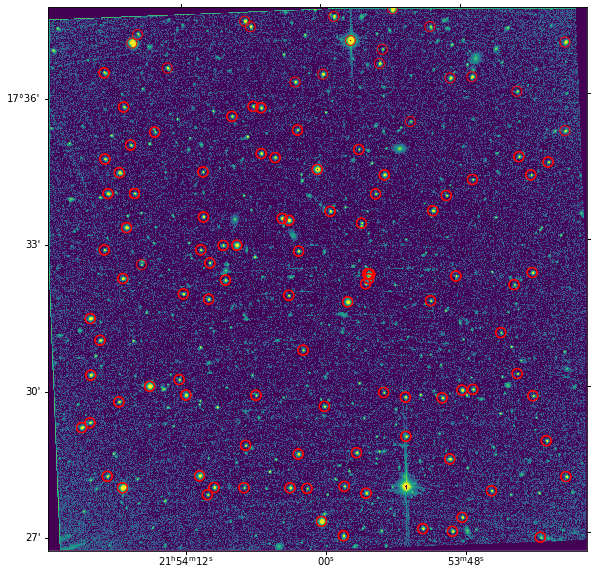

In [5]:
plt.figure(figsize=(10,10))
ax = plt.subplot(projection=datacube.wcs)
plt.scatter(star_match_pos[:,0], star_match_pos[:,1], s=100, facecolor="none", edgecolor="r")
plt.imshow(datacube.src_map, norm=norm1, origin="lower", vmin=np.median(datacube.src_map), vmax=1)

### Measure distance

In [6]:
dist_to_edge = measure_dist_to_edge(datacube.table, datacube.mask_edge, pad=200)

### Measure EW

(37.680826809915516, 4.152616620061053)

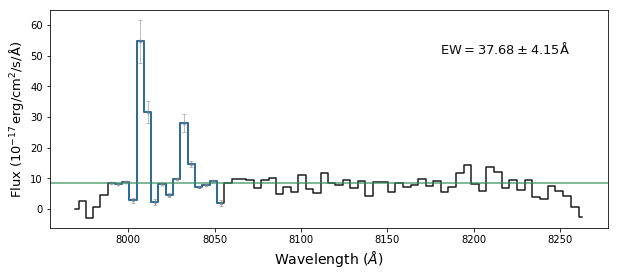

In [26]:
datacube.estimate_EW(1137, sigma=5, MC_err=True)

(115.32816172286277, 57.67095157624826)

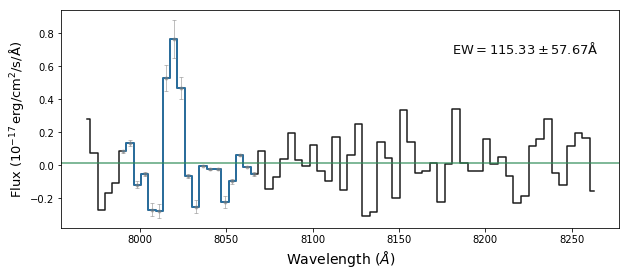

In [27]:
datacube.estimate_EW(30, sigma=5, MC_err=True)

In [20]:
datacube.estimate_EW_all(MC_err=True, sigma=5)

Measure EW... 400/3929
Measure EW... 800/3929
Measure EW... 1200/3929
Measure EW... 1600/3929
Measure EW... 2000/3929
Measure EW... 2400/3929
Measure EW... 2800/3929
Measure EW... 3200/3929
Measure EW... 3600/3929


In [40]:
good_channel = (np.argmax(datacube.obj_specs_opt, axis=1)>6)

### Conditions

In [41]:
EW_cond = (datacube.EWs > datacube.EW_stds) & (datacube.EWs > 5)
edge_cond = dist_to_edge > 5

SNR_min_gauss = np.min([SNR_best_Ha_gauss, SNR_best_OIII_gauss, SNR_best_OII_gauss], axis=0)
SNR_min_cond = SNR_min_gauss > 3

SNR_cond_A = (SNR_best_Ha_gauss > 8) & (SNR_best_OII_gauss>3)
SNR_cond_B = (SNR_best_Ha_gauss > 5) & (SNR_best_Ha_gauss <= 8) & (SNR_best_OII_gauss>5)

zmin_OIII = datacube.wavl.min()/4959-1
# SN OIII > 5, SN OIII > SN Ha, SN OIII > SN OII 
SNR_cond_C = (SNR_best_OIII_gauss > np.max([5*np.ones_like(datacube.obj_nums), SNR_best_Ha_gauss], axis=0)) \
            & SNR_min_cond & (z_best_OIII_gauss>zmin_OIII)

num_c = datacube.obj_nums[EW_cond & SNR_cond_A & edge_cond & good_channel]

# remove stars and possible artifacts
num_c = np.setdiff1d(num_c, cat_match["NUMBER"])
num_c = np.setdiff1d(num_c, datacube.num_spurious)
print(num_c)
print(len(num_c))

[  30   45  198  373  454  526  541  611  618  638  681  807  809  822
  867  925  958 1102 1108 1137 1149 1200 1269 1344 1352 1487 1510 1583
 1593 1615 1676 1826 1876 1936 2135 2146 2164 2165 2183 2211 2341 2443
 2448 2499 2571 2692 2776 2835 2930 2946 2986 3027 3073 3099 3219 3231
 3259 3278 3328 3437 3467 3472 3474 3490 3515 3539 3603 3613 3792 3813
 3830 3831 3913 3918 3923 3926]
76


In [35]:
v = 'C'
save_path = './A2390SE/fig_iso/candidate/%s'%v
check_save_path(save_path, clear=True)
for k, num in enumerate(num_c):
    if np.mod(k+1, 40)==0: print("Plot: %d/%d"%(k+1, len(num_c)))
    datacube.plot_candidate(num, temp_type="Hb-OIII", temp_model="gauss")
    plt.savefig(os.path.join(save_path, "#%d.png"%num),dpi=75)
    plt.title("Sample %s"%v)
    plt.close()

./A2390SE/fig_iso/candidate/C exists. Remove all the content.


In [27]:
result = datacube.cross_correlation(1876, temp_type="Ha-NII", edge=20, const_window=False, temp_model="gauss")

Detection #1876  z: 0.245  sigma: 3.018  Peak R: 6.850  Detction S/N: 9.608 Peak S/N: 9.968


Detection #1876  z: 0.632  sigma: 2.220  Peak R: 2.797  Detction S/N: 10.101 Peak S/N: 10.101


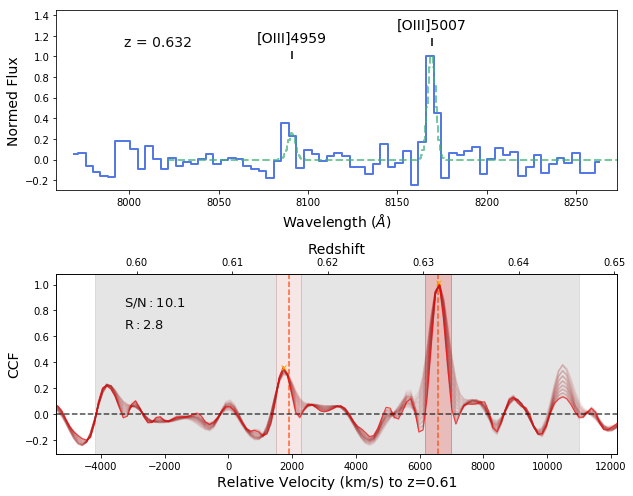

In [28]:
result = datacube.cross_correlation(1876, temp_type="Hb-OIII", edge=20, const_window=False, temp_model="gauss")

Detection #3813  z: 0.636  sigma: 3.418  Peak R: 2.612  Detction S/N: 10.292 Peak S/N: 10.292


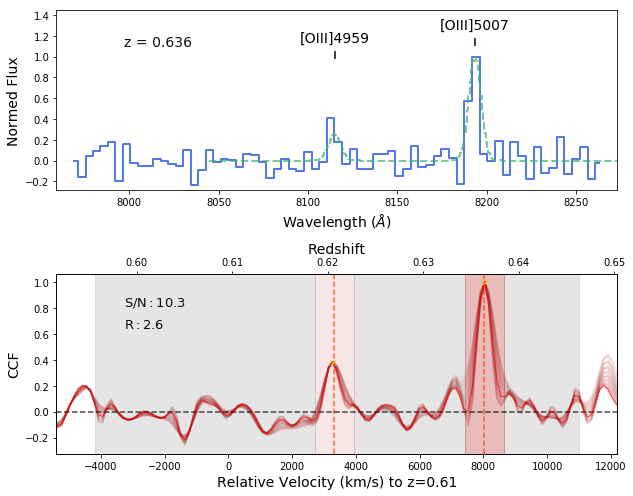

In [18]:
result = datacube.cross_correlation(3813, temp_type="Hb-OIII", edge=20, const_window=False, temp_model="gauss")

Detection #3813  z: 0.248  sigma: 2.220  Peak R: 5.617  Detction S/N: 10.901 Peak S/N: 10.639


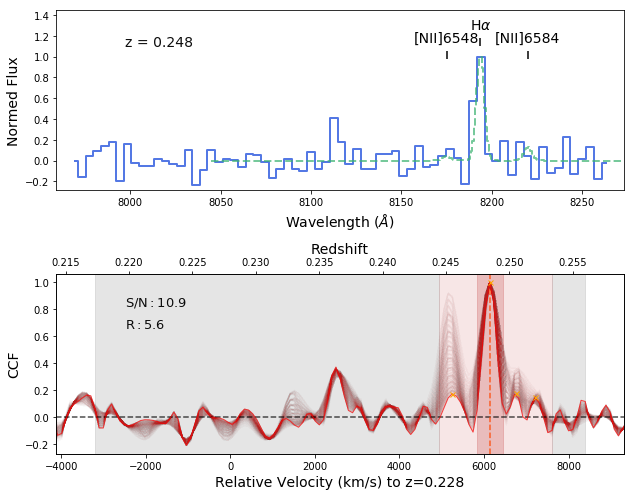

In [19]:
result = datacube.cross_correlation(3813, temp_type="Ha-NII", edge=20, const_window=False, temp_model="gauss")

## 6. Measure Centroid

In [2]:
from pipeline import *
from utils import *

%load_ext autoreload
%autoreload 2

In [3]:
datacube = Read_Datacube('./proc/A2390E/A2390E_cube.fits', 
                         name='A2390E', z0=0.228, mode="MMA",
                         table='./proc/A2390E/A2390E_MMA.dat', 
                         seg_map='./proc/A2390E/A2390E_segm_MMA.fits',
                         deep_frame='./proc/A2390E/A2390E_DF.fits',
                         mask_edge='./proc/A2390E/Raw_stack_A2390E_mask.fits')
datacube.get_wcs()
datacube.src_map = fits.open('./proc/A2390E_MMA.fits')[0].data
datacube.read_spec('./proc/A2390E/A2390E-spec-MMA_all.fits')
datacube.Read_Template('./proc/template/', n_intp=2, name='A2390E')
datacube.read_cc_result('./proc/A2390E/A2390E-cc.pkl')

Read Emission Line Template:
['./proc/template/Template-A2390C_Ha-NII_gauss.fits',
 './proc/template/Template-A2390C_Hb-OIII_gauss.fits',
 './proc/template/Template-A2390C_OII_gauss.fits',
 './proc/template/Template-A2390C_Ha-NII_box.fits',
 './proc/template/Template-A2390C_Hb-OIII_box.fits',
 './proc/template/Template-A2390C_OII_box.fits',
 './proc/template/Template-A2465C_Ha-NII_gauss.fits',
 './proc/template/Template-A2465C_Hb-OIII_gauss.fits',
 './proc/template/Template-A2465C_OII_gauss.fits',
 './proc/template/Template-A2465C_Ha-NII_box.fits',
 './proc/template/Template-A2465C_Hb-OIII_box.fits',
 './proc/template/Template-A2465C_OII_box.fits',
 './proc/template/Template-A2390E_Ha-NII_gauss.fits',
 './proc/template/Template-A2390E_Hb-OIII_gauss.fits',
 './proc/template/Template-A2390E_OII_gauss.fits',
 './proc/template/Template-A2390E_Ha-NII_box.fits',
 './proc/template/Template-A2390E_Hb-OIII_box.fits',
 './proc/template/Template-A2390E_OII_box.fits',
 './proc/template/Template-A2

In [3]:
el_v = glob.glob("./A2390SE/fig_iso/candidate/V/#*.png")
Num_v_all = np.sort(np.array([re.compile(r'\d+').findall(el)[-1] for el in el_v]).astype("int"))
Num_non = [3813, 3539]
Num_v = np.setdiff1d(Num_v_all, Num_non)
Num_v

array([  45,  105,  198,  268,  348,  370,  377,  394,  440,  454,  507,
        526,  529,  531,  541,  557,  611,  618,  681,  688,  784,  807,
        809,  822,  892,  895,  925,  934,  954,  958,  982,  988, 1102,
       1108, 1137, 1195, 1197, 1212, 1269, 1369, 1487, 1510, 1583, 1593,
       1632, 1641, 1664, 1686, 1715, 1732, 1784, 1876, 1974, 2113, 2146,
       2165, 2183, 2291, 2298, 2318, 2321, 2341, 2387, 2443, 2448, 2499,
       2546, 2571, 2692, 2762, 2776, 2836, 2984, 3027, 3031, 3037, 3059,
       3219, 3228, 3287, 3328, 3401, 3423, 3436, 3437, 3467, 3468, 3472,
       3490, 3515, 3585, 3594, 3613, 3616, 3752, 3792, 3830, 3831, 3839,
       3921])

In [4]:
datacube.assign_BCG_coordinate((328.40351201,17.69544013))
X_BCG, Y_BCG = datacube.wcs.all_world2pix(datacube.coord_BCG.ra, datacube.coord_BCG.dec, 0)
datacube.pos_BCG = (X_BCG, Y_BCG)

BCG coordinate:  21h53m36.8429s +17d41m43.5845s


Error of light-wighted centroid: $\sigma_{\left<x\right>} = \Sigma_j \frac{\sigma^2_{I_j} \cdot (x_j-\left<x\right>)^2}{\Sigma_i I_i^2}$

http://ugastro.berkeley.edu/infrared09/PDF-2009/centroid-error.pdf

In [34]:
num = 3472
datacube.centroid_analysis(num, centroid_type="APER", smooth=False)

stddev emission: 0.015 / continuum: 0.003
Centroid EM: (1410.09+/-0.03, 341.54+/-0.01)
Centroid CON: (1409.61+/-0.01, 340.16+/-0.00)


{'diff_angle': 176.0308477017233,
 'cen_offset': 1.4594636189576113,
 'diff_angle_std': 1.1232392578423043,
 'cen_offset_std': 0.013009078601541635,
 'pa': 160.83150139571512,
 'clus_cen_angle': 344.8006536939918,
 'dist_clus_cen': 2552.046675901292}

stddev emission: 0.015 / continuum: 0.003
Centroid EM: (1409.91+/-0.03, 341.63+/-0.01)
Centroid CON: (1409.51+/-0.01, 340.01+/-0.00)


{'diff_angle': 178.7768097007381,
 'cen_offset': 1.6733984987308195,
 'diff_angle_std': 1.0122414636636985,
 'cen_offset_std': 0.014396396217128838,
 'pa': 166.0238439932537,
 'clus_cen_angle': 344.8006536939918,
 'dist_clus_cen': 2552.046675901292}

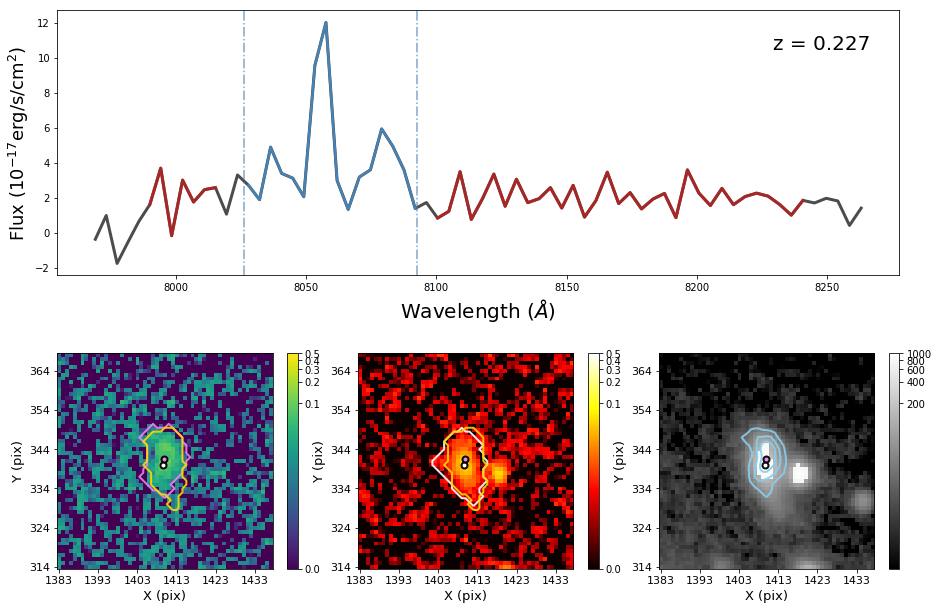

In [5]:
num = 3472
datacube.centroid_analysis(num, centroid_type="ISO-D", smooth=False)

stddev emission: 0.015 / continuum: 0.003
Centroid EM: (1409.69+/-0.08, 341.67+/-0.08)
Centroid CON: (1409.33+/-0.08, 339.98+/-0.08)


{'diff_angle': 177.11312700018647,
 'cen_offset': 1.732782993618071,
 'diff_angle_std': 3.6994659993344245,
 'cen_offset_std': 0.11188209364795004,
 'pa': 167.68752669380535,
 'clus_cen_angle': 344.8006536939918,
 'dist_clus_cen': 2552.046675901292}

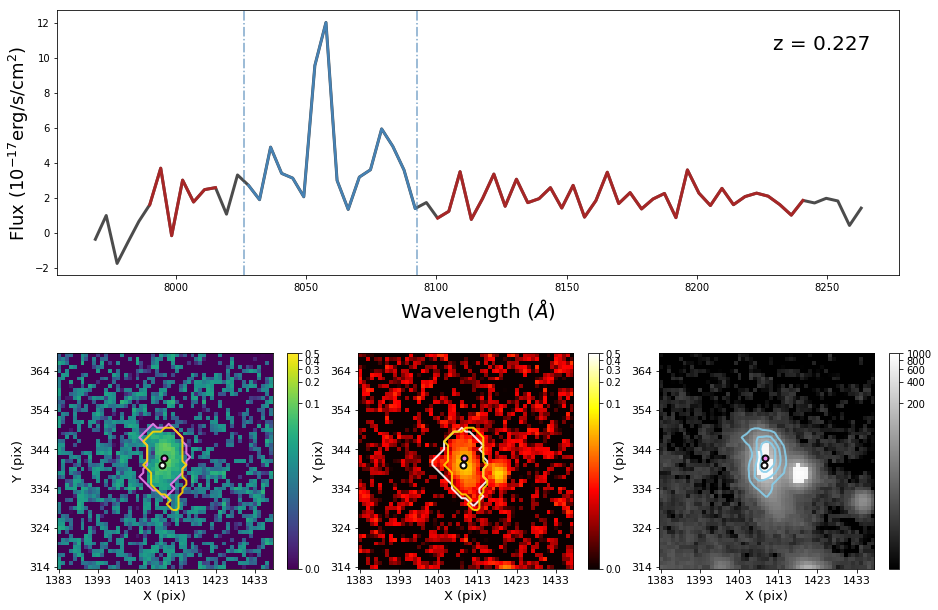

In [30]:
num = 3472
datacube.centroid_analysis(num, centroid_type="ISO-D", morph_cen=True, smooth=False)

stddev emission: 0.012 / continuum: 0.003
Centroid EM: (978.08+/-0.00, 1317.65+/-0.00)
Centroid CON: (975.97+/-0.00, 1314.31+/-0.00)


{'diff_angle': 13.156359423537822,
 'cen_offset': 3.951810447897986,
 'diff_angle_std': 0.04455097614300079,
 'cen_offset_std': 0.003014803243723794,
 'pa': 147.56107964221655,
 'clus_cen_angle': 134.40472021867873,
 'dist_clus_cen': 1.432253911610841}

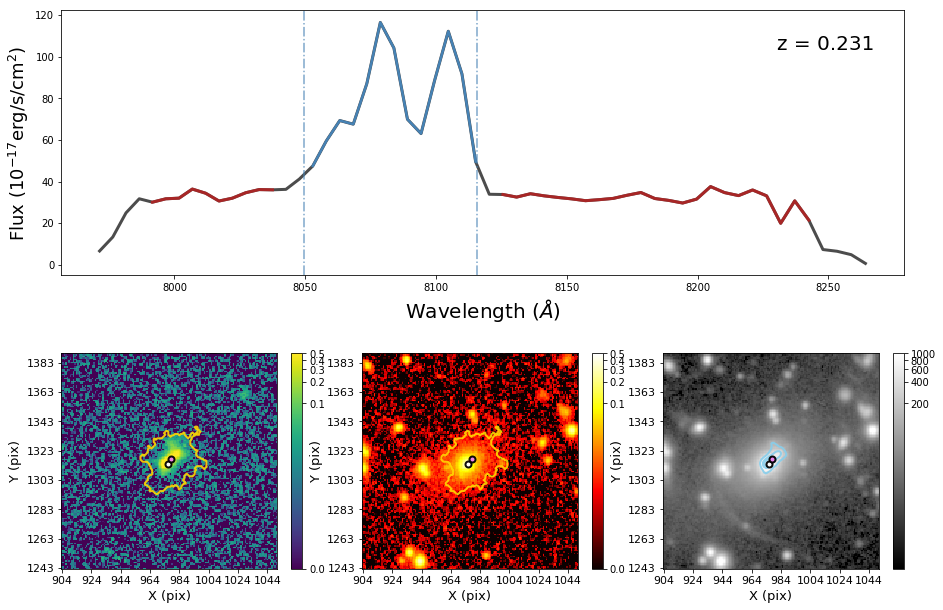

In [10]:
num = 2671
datacube.centroid_analysis(num, centroid_type="ISO", smooth=False)

In [6]:
datacube.centroid_analysis_all(Num_v_all, nums_obj=Num_v_all, centroid_type="APER")


Candidate: #45
stddev emission: 0.015 / continuum: 0.004
Centroid EM: (351.48+/-0.01, 33.55+/-0.01)
Centroid CON: (351.70+/-0.02, 33.58+/-0.02)
Angle: 50.28 +/- 6.53
Offset: 0.22 +/- 0.03

Candidate: #105
stddev emission: 0.011 / continuum: 0.004
Centroid EM: (1005.76+/-0.25, 59.33+/-0.40)
Centroid CON: (1005.78+/-1.78, 58.16+/-2.28)
Angle: 157.24 +/- 88.35
Offset: 1.17 +/- 2.32

Candidate: #198
stddev emission: 0.014 / continuum: 0.004
Centroid EM: (1742.74+/-0.01, 119.39+/-0.01)
Centroid CON: (1742.81+/-0.01, 119.14+/-0.01)
Angle: 156.93 +/- 2.31
Offset: 0.26 +/- 0.01

Candidate: #268
stddev emission: 0.015 / continuum: 0.004

Candidate: #348
stddev emission: 0.015 / continuum: 0.003
Centroid EM: (1212.41+/-0.37, 183.67+/-0.49)
Centroid CON: (1214.63+/-0.01, 181.16+/-0.02)
Angle: 120.07 +/- 7.28
Offset: 3.35 +/- 0.44

Candidate: #370
stddev emission: 0.012 / continuum: 0.004

Candidate: #377
stddev emission: 0.012 / continuum: 0.004

Candidate: #394
stddev emission: 0.015 / continuu


Candidate: #2571
stddev emission: 0.012 / continuum: 0.003
Centroid EM: (538.47+/-0.00, 1566.52+/-0.00)
Centroid CON: (538.26+/-0.01, 1565.79+/-0.01)
Angle: 144.68 +/- 0.86
Offset: 0.76 +/- 0.01

Candidate: #2692
stddev emission: 0.014 / continuum: 0.004

Candidate: #2762
stddev emission: 0.014 / continuum: 0.003

Candidate: #2776
stddev emission: 0.013 / continuum: 0.003

Candidate: #2836
stddev emission: 0.016 / continuum: 0.003

Candidate: #2984
stddev emission: 0.017 / continuum: 0.003

Candidate: #3027
stddev emission: 0.014 / continuum: 0.004
Centroid EM: (1962.85+/-0.01, 1855.92+/-0.01)
Centroid CON: (1964.00+/-0.10, 1854.77+/-0.09)
Angle: 128.59 +/- 3.34
Offset: 1.63 +/- 0.09

Candidate: #3031
stddev emission: 0.014 / continuum: 0.003

Candidate: #3037
stddev emission: 0.012 / continuum: 0.004

Candidate: #3059
stddev emission: 0.014 / continuum: 0.003

Candidate: #3219
stddev emission: 0.012 / continuum: 0.003

Candidate: #3228
stddev emission: 0.017 / continuum: 0.003

Candi

In [7]:
datacube.centroid_analysis_all(Num_v_all, nums_obj=Num_v_all, centroid_type="ISO-D", morph_cen=False)


Candidate: #45
stddev emission: 0.015 / continuum: 0.004
Centroid EM: (351.41+/-0.02, 33.53+/-0.02)
Centroid CON: (352.02+/-0.05, 33.97+/-0.04)
Angle: 22.66 +/- 3.28
Offset: 0.75 +/- 0.05

Candidate: #105
stddev emission: 0.011 / continuum: 0.004

Candidate: #198
stddev emission: 0.014 / continuum: 0.004
Centroid EM: (1742.62+/-0.02, 119.58+/-0.01)
Centroid CON: (1742.75+/-0.01, 119.08+/-0.01)
Angle: 157.55 +/- 2.29
Offset: 0.51 +/- 0.02

Candidate: #268
stddev emission: 0.015 / continuum: 0.004

Candidate: #348
stddev emission: 0.015 / continuum: 0.003

Candidate: #370
stddev emission: 0.012 / continuum: 0.004

Candidate: #377
stddev emission: 0.012 / continuum: 0.004

Candidate: #394
stddev emission: 0.015 / continuum: 0.004

Candidate: #440


stddev emission: 0.014 / continuum: 0.003

Candidate: #454
stddev emission: 0.012 / continuum: 0.004

Candidate: #507
stddev emission: 0.013 / continuum: 0.003

Candidate: #526
stddev emission: 0.014 / continuum: 0.003

Candidate: #529
stddev emission: 0.018 / continuum: 0.004

Candidate: #531
stddev emission: 0.013 / continuum: 0.003
Centroid EM: (1093.81+/-0.09, 269.70+/-0.10)
Centroid CON: (1090.50+/-0.00, 272.07+/-0.00)
Angle: 75.69 +/- 1.32
Offset: 4.07 +/- 0.09

Candidate: #541
stddev emission: 0.014 / continuum: 0.003

Candidate: #557
stddev emission: 0.013 / continuum: 0.004



Candidate: #611
stddev emission: 0.013 / continuum: 0.004

Candidate: #618
stddev emission: 0.014 / continuum: 0.003
Centroid EM: (1457.17+/-0.04, 321.13+/-0.05)
Centroid CON: (1457.70+/-0.02, 321.83+/-0.03)
Angle: 23.13 +/- 3.22
Offset: 0.87 +/- 0.05

Candidate: #681
stddev emission: 0.012 / continuum: 0.004
Centroid EM: (1938.45+/-0.04, 366.38+/-0.06)
Centroid CON: (1939.25+/-0.03, 364.26+/-0.02)
Angle: 155.96 +/- 1.34
Offset: 2.26 +/- 0.06

Candidate: #688
stddev emission: 0.012 / continuum: 0.003

Candidate: #784
stddev emission: 0.015 / continuum: 0.003

Candidate: #807
stddev emission: 0.014 / continuum: 0.003

Candidate: #809
stddev emission: 0.013 / continuum: 0.004
Centroid EM: (1275.61+/-0.04, 429.51+/-0.03)
Centroid CON: (1275.35+/-0.01, 429.25+/-0.01)
Angle: 154.13 +/- 5.26
Offset: 0.37 +/- 0.03

Candidate: #822
stddev emission: 0.013 / continuum: 0.004

Candidate: #892
stddev emission: 0.015 / continuum: 0.003

Candidate: #895


stddev emission: 0.017 / continuum: 0.003
Centroid EM: (726.06+/-0.03, 486.11+/-0.04)
Centroid CON: (726.24+/-0.04, 487.94+/-0.04)
Angle: 24.69 +/- 1.38
Offset: 1.85 +/- 0.05

Candidate: #925
stddev emission: 0.013 / continuum: 0.003
Centroid EM: (1589.68+/-0.11, 505.80+/-0.04)
Centroid CON: (1589.50+/-0.02, 504.38+/-0.01)
Angle: 175.62 +/- 4.26
Offset: 1.43 +/- 0.05

Candidate: #934
stddev emission: 0.013 / continuum: 0.003

Candidate: #954
stddev emission: 0.017 / continuum: 0.003

Candidate: #958
stddev emission: 0.013 / continuum: 0.003
Centroid EM: (482.42+/-0.04, 516.05+/-0.04)
Centroid CON: (483.32+/-0.04, 516.58+/-0.04)
Angle: 24.43 +/- 3.12
Offset: 1.05 +/- 0.06

Candidate: #982
stddev emission: 0.012 / continuum: 0.004

Candidate: #988
stddev emission: 0.013 / continuum: 0.004

Candidate: #1102
stddev emission: 0.014 / continuum: 0.004
Centroid EM: (1888.04+/-0.03, 597.27+/-0.03)
Centroid CON: (1888.62+/-0.04, 598.23+/-0.04)
Angle: 26.04 +/- 2.65
Offset: 1.13 +/- 0.05

Candid

stddev emission: 0.014 / continuum: 0.003
Centroid EM: (1744.32+/-0.01, 628.07+/-0.01)
Centroid CON: (1744.22+/-0.00, 629.03+/-0.01)
Angle: 14.10 +/- 0.59
Offset: 0.96 +/- 0.01

Candidate: #1195
stddev emission: 0.011 / continuum: 0.004

Candidate: #1197
stddev emission: 0.014 / continuum: 0.003

Candidate: #1212
stddev emission: 0.011 / continuum: 0.003

Candidate: #1269
stddev emission: 0.013 / continuum: 0.004

Candidate: #1369
stddev emission: 0.013 / continuum: 0.003

Candidate: #1487
stddev emission: 0.014 / continuum: 0.003
Centroid EM: (629.54+/-0.02, 833.15+/-0.03)
Centroid CON: (628.21+/-0.02, 832.80+/-0.03)
Angle: 140.94 +/- 1.62
Offset: 1.38 +/- 0.03

Candidate: #1510
stddev emission: 0.013 / continuum: 0.003

Candidate: #1583
stddev emission: 0.012 / continuum: 0.003

Candidate: #1593
stddev emission: 0.013 / continuum: 0.003
Centroid EM: (373.76+/-0.01, 904.06+/-0.01)
Centroid CON: (373.70+/-0.01, 905.02+/-0.00)
Angle: 45.45 +/- 0.89
Offset: 0.95 +/- 0.01

Candidate: #163

stddev emission: 0.012 / continuum: 0.003

Candidate: #1641
stddev emission: 0.011 / continuum: 0.003

Candidate: #1664
stddev emission: 0.017 / continuum: 0.003

Candidate: #1686
stddev emission: 0.012 / continuum: 0.004

Candidate: #1715
stddev emission: 0.014 / continuum: 0.003

Candidate: #1732
stddev emission: 0.018 / continuum: 0.003

Candidate: #1784
stddev emission: 0.011 / continuum: 0.004

Candidate: #1876
stddev emission: 0.012 / continuum: 0.004

Candidate: #1974
stddev emission: 0.015 / continuum: 0.003
Centroid EM: (1468.12+/-0.98, 1125.64+/-0.77)
Centroid CON: (1471.57+/-0.00, 1124.37+/-0.00)
Angle: 90.67 +/- 12.47
Offset: 3.68 +/- 0.96

Candidate: #2113
stddev emission: 0.010 / continuum: 0.003

Candidate: #2146


stddev emission: 0.012 / continuum: 0.004
Centroid EM: (1090.22+/-0.14, 1251.35+/-0.14)
Centroid CON: (1089.34+/-0.13, 1251.32+/-0.07)
Angle: 124.50 +/- 10.26
Offset: 0.88 +/- 0.19

Candidate: #2165
stddev emission: 0.013 / continuum: 0.003
Centroid EM: (473.92+/-0.02, 1271.27+/-0.01)
Centroid CON: (474.48+/-0.01, 1270.87+/-0.01)
Angle: 79.23 +/- 1.36
Offset: 0.69 +/- 0.02

Candidate: #2183
stddev emission: 0.012 / continuum: 0.004
Centroid EM: (1050.87+/-0.03, 1291.08+/-0.04)
Centroid CON: (1048.76+/-0.01, 1290.92+/-0.01)
Angle: 128.42 +/- 1.18
Offset: 2.12 +/- 0.04

Candidate: #2291
stddev emission: 0.014 / continuum: 0.003

Candidate: #2298
stddev emission: 0.013 / continuum: 0.003

Candidate: #2318
stddev emission: 0.015 / continuum: 0.003

Candidate: #2321
stddev emission: 0.018 / continuum: 0.003

Candidate: #2341
stddev emission: 0.014 / continuum: 0.003
Centroid EM: (964.12+/-0.01, 1404.33+/-0.00)
Centroid CON: (964.31+/-0.00, 1404.77+/-0.00)
Angle: 14.83 +/- 0.71
Offset: 0.47 


Candidate: #2448
stddev emission: 0.012 / continuum: 0.003
Centroid EM: (432.86+/-0.05, 1475.66+/-0.12)
Centroid CON: (433.76+/-0.05, 1476.45+/-0.05)
Angle: 2.48 +/- 5.16
Offset: 1.20 +/- 0.10

Candidate: #2499
stddev emission: 0.013 / continuum: 0.003
Centroid EM: (1702.23+/-0.01, 1509.24+/-0.02)
Centroid CON: (1702.74+/-0.02, 1508.43+/-0.02)
Angle: 132.34 +/- 1.22
Offset: 0.95 +/- 0.02

Candidate: #2546
stddev emission: 0.014 / continuum: 0.003

Candidate: #2571
stddev emission: 0.012 / continuum: 0.003
Centroid EM: (538.42+/-0.00, 1566.55+/-0.00)
Centroid CON: (538.09+/-0.02, 1565.33+/-0.01)
Angle: 143.87 +/- 0.79
Offset: 1.26 +/- 0.02

Candidate: #2692
stddev emission: 0.014 / continuum: 0.004

Candidate: #2762
stddev emission: 0.014 / continuum: 0.003

Candidate: #2776
stddev emission: 0.013 / continuum: 0.003

Candidate: #2836
stddev emission: 0.016 / continuum: 0.003
Centroid EM: (821.13+/-1.24, 1726.76+/-5.21)
Centroid CON: (821.27+/-0.01, 1727.04+/-0.01)
Angle: 22.48 +/- 472.

Centroid EM: (1962.95+/-0.02, 1856.23+/-0.02)
Centroid CON: (1964.11+/-0.09, 1854.89+/-0.12)
Angle: 132.50 +/- 3.39
Offset: 1.78 +/- 0.11

Candidate: #3031
stddev emission: 0.014 / continuum: 0.003

Candidate: #3037
stddev emission: 0.012 / continuum: 0.004

Candidate: #3059
stddev emission: 0.014 / continuum: 0.003

Candidate: #3219
stddev emission: 0.012 / continuum: 0.003

Candidate: #3228
stddev emission: 0.017 / continuum: 0.003

Candidate: #3287
stddev emission: 0.015 / continuum: 0.003

Candidate: #3328
stddev emission: 0.012 / continuum: 0.003

Candidate: #3401
stddev emission: 0.014 / continuum: 0.002

Candidate: #3423
stddev emission: 0.014 / continuum: 0.004



Candidate: #3436
stddev emission: 0.016 / continuum: 0.003

Candidate: #3437
stddev emission: 0.013 / continuum: 0.004

Candidate: #3467
stddev emission: 0.013 / continuum: 0.004
Centroid EM: (339.82+/-0.00, 272.10+/-0.00)
Centroid CON: (339.74+/-0.01, 271.24+/-0.01)
Angle: 150.74 +/- 0.56
Offset: 0.87 +/- 0.01

Candidate: #3468
stddev emission: 0.012 / continuum: 0.004

Candidate: #3472
stddev emission: 0.014 / continuum: 0.003
Centroid EM: (1409.92+/-0.03, 341.71+/-0.01)
Centroid CON: (1409.64+/-0.01, 340.34+/-0.00)
Angle: 176.44 +/- 1.18
Offset: 1.40 +/- 0.01

Candidate: #3490
stddev emission: 0.014 / continuum: 0.004
Centroid EM: (1509.62+/-0.02, 377.82+/-0.02)
Centroid CON: (1509.14+/-0.03, 378.59+/-0.02)
Angle: 45.52 +/- 2.04
Offset: 0.91 +/- 0.03

Candidate: #3515
stddev emission: 0.013 / continuum: 0.003
Centroid EM: (750.25+/-0.05, 520.62+/-0.10)
Centroid CON: (750.26+/-0.01, 522.57+/-0.02)
Angle: 30.13 +/- 1.59
Offset: 1.95 +/- 0.10

Candidate: #3585
stddev emission: 0.015 /

stddev emission: 0.013 / continuum: 0.004
Centroid EM: (892.38+/-0.37, 1244.47+/-0.35)
Centroid CON: (893.00+/-0.01, 1239.31+/-0.00)
Angle: 136.00 +/- 4.09
Offset: 5.19 +/- 0.35

Candidate: #3830
stddev emission: 0.013 / continuum: 0.003
Centroid EM: (736.03+/-0.04, 1561.46+/-0.05)
Centroid CON: (741.89+/-0.20, 1564.15+/-0.11)
Angle: 18.01 +/- 1.26
Offset: 6.44 +/- 0.20

Candidate: #3831
stddev emission: 0.012 / continuum: 0.003
Centroid EM: (757.10+/-0.00, 1571.20+/-0.00)
Centroid CON: (754.52+/-0.01, 1570.71+/-0.01)
Angle: 147.79 +/- 0.18
Offset: 2.63 +/- 0.01

Candidate: #3839
stddev emission: 0.013 / continuum: 0.004

Candidate: #3921
stddev emission: 0.015 / continuum: 0.004


In [8]:
datacube.centroid_analysis_all(Num_v_all, nums_obj=Num_v_all, centroid_type="ISO-D", morph_cen=True)


Candidate: #45
stddev emission: 0.015 / continuum: 0.004
Centroid EM: (351.35+/-0.12, 33.54+/-0.12)
Centroid CON: (351.79+/-0.11, 33.78+/-0.11)
Angle: 29.14 +/- 19.17
Offset: 0.50 +/- 0.17

Candidate: #105


stddev emission: 0.011 / continuum: 0.004

Candidate: #198
stddev emission: 0.014 / continuum: 0.004
Centroid EM: (1742.16+/-0.11, 119.92+/-0.11)
Centroid CON: (1742.62+/-0.11, 119.21+/-0.11)
Angle: 139.80 +/- 10.53
Offset: 0.84 +/- 0.15

Candidate: #268
stddev emission: 0.015 / continuum: 0.004

Candidate: #348
stddev emission: 0.015 / continuum: 0.003

Candidate: #370
stddev emission: 0.012 / continuum: 0.004

Candidate: #377
stddev emission: 0.012 / continuum: 0.004

Candidate: #394
stddev emission: 0.015 / continuum: 0.004

Candidate: #440
stddev emission: 0.014 / continuum: 0.003

Candidate: #454
stddev emission: 0.012 / continuum: 0.004

Candidate: #507


stddev emission: 0.013 / continuum: 0.003

Candidate: #526
stddev emission: 0.014 / continuum: 0.003

Candidate: #529
stddev emission: 0.018 / continuum: 0.004

Candidate: #531
stddev emission: 0.013 / continuum: 0.003
Centroid EM: (1093.77+/-0.09, 269.87+/-0.09)
Centroid CON: (1091.89+/-0.07, 271.72+/-0.07)
Angle: 66.87 +/- 2.39
Offset: 2.64 +/- 0.11

Candidate: #541
stddev emission: 0.014 / continuum: 0.003

Candidate: #557
stddev emission: 0.013 / continuum: 0.004

Candidate: #611
stddev emission: 0.013 / continuum: 0.004

Candidate: #618
stddev emission: 0.014 / continuum: 0.003
Centroid EM: (1457.07+/-0.12, 321.01+/-0.12)
Centroid CON: (1457.91+/-0.11, 321.68+/-0.11)
Angle: 37.62 +/- 8.66
Offset: 1.07 +/- 0.16

Candidate: #681
stddev emission: 0.012 / continuum: 0.004
Centroid EM: (1937.90+/-0.14, 366.25+/-0.14)
Centroid CON: (1939.14+/-0.09, 364.57+/-0.09)
Angle: 140.28 +/- 4.54
Offset: 2.09 +/- 0.17

Candidate: #688
stddev emission: 0.012 / continuum: 0.003



Candidate: #784
stddev emission: 0.015 / continuum: 0.003

Candidate: #807
stddev emission: 0.014 / continuum: 0.003

Candidate: #809
stddev emission: 0.013 / continuum: 0.004
Centroid EM: (1275.37+/-0.12, 430.09+/-0.12)
Centroid CON: (1275.23+/-0.11, 429.39+/-0.11)
Angle: 173.23 +/- 13.18
Offset: 0.71 +/- 0.16

Candidate: #822
stddev emission: 0.013 / continuum: 0.004

Candidate: #892
stddev emission: 0.015 / continuum: 0.003

Candidate: #895
stddev emission: 0.017 / continuum: 0.003
Centroid EM: (725.63+/-0.14, 485.96+/-0.14)
Centroid CON: (726.18+/-0.12, 487.90+/-0.12)
Angle: 14.43 +/- 5.13
Offset: 2.02 +/- 0.18

Candidate: #925
stddev emission: 0.013 / continuum: 0.003
Centroid EM: (1589.51+/-0.14, 505.58+/-0.14)
Centroid CON: (1589.75+/-0.09, 504.23+/-0.09)
Angle: 158.07 +/- 6.80
Offset: 1.38 +/- 0.16

Candidate: #934
stddev emission: 0.013 / continuum: 0.003

Candidate: #954


stddev emission: 0.017 / continuum: 0.003

Candidate: #958
stddev emission: 0.013 / continuum: 0.003
Centroid EM: (482.25+/-0.13, 516.41+/-0.13)
Centroid CON: (483.55+/-0.12, 516.46+/-0.12)
Angle: 52.68 +/- 7.96
Offset: 1.30 +/- 0.18

Candidate: #982
stddev emission: 0.012 / continuum: 0.004

Candidate: #988
stddev emission: 0.013 / continuum: 0.004

Candidate: #1102
stddev emission: 0.014 / continuum: 0.004
Centroid EM: (1888.12+/-0.12, 597.37+/-0.12)
Centroid CON: (1888.87+/-0.13, 598.54+/-0.13)
Angle: 27.57 +/- 7.35
Offset: 1.39 +/- 0.18

Candidate: #1108
stddev emission: 0.012 / continuum: 0.003

Candidate: #1137
stddev emission: 0.014 / continuum: 0.003
Centroid EM: (1744.61+/-0.05, 627.94+/-0.05)
Centroid CON: (1744.18+/-0.04, 628.86+/-0.04)
Angle: 34.23 +/- 3.73
Offset: 1.02 +/- 0.07

Candidate: #1195
stddev emission: 0.011 / continuum: 0.004

Candidate: #1197
stddev emission: 0.014 / continuum: 0.003



Candidate: #1212
stddev emission: 0.011 / continuum: 0.003

Candidate: #1269
stddev emission: 0.013 / continuum: 0.004

Candidate: #1369
stddev emission: 0.013 / continuum: 0.003

Candidate: #1487
stddev emission: 0.014 / continuum: 0.003
Centroid EM: (629.58+/-0.10, 832.75+/-0.10)
Centroid CON: (627.81+/-0.09, 832.72+/-0.09)
Angle: 127.48 +/- 4.34
Offset: 1.77 +/- 0.13

Candidate: #1510
stddev emission: 0.013 / continuum: 0.003

Candidate: #1583
stddev emission: 0.012 / continuum: 0.003

Candidate: #1593
stddev emission: 0.013 / continuum: 0.003
Centroid EM: (374.03+/-0.08, 903.71+/-0.08)
Centroid CON: (373.88+/-0.07, 905.46+/-0.07)
Angle: 47.05 +/- 3.35
Offset: 1.75 +/- 0.10

Candidate: #1632
stddev emission: 0.012 / continuum: 0.003

Candidate: #1641
stddev emission: 0.011 / continuum: 0.003

Candidate: #1664


stddev emission: 0.017 / continuum: 0.003

Candidate: #1686
stddev emission: 0.012 / continuum: 0.004

Candidate: #1715
stddev emission: 0.014 / continuum: 0.003

Candidate: #1732
stddev emission: 0.018 / continuum: 0.003

Candidate: #1784
stddev emission: 0.011 / continuum: 0.004

Candidate: #1876
stddev emission: 0.012 / continuum: 0.004

Candidate: #1974
stddev emission: 0.015 / continuum: 0.003
Centroid EM: (1468.27+/-0.17, 1126.18+/-0.17)
Centroid CON: (1471.54+/-0.10, 1124.33+/-0.10)
Angle: 100.02 +/- 3.07
Offset: 3.76 +/- 0.20

Candidate: #2113
stddev emission: 0.010 / continuum: 0.003

Candidate: #2146
stddev emission: 0.012 / continuum: 0.004
Centroid EM: (1089.82+/-0.17, 1251.82+/-0.17)
Centroid CON: (1088.93+/-0.12, 1250.85+/-0.12)
Angle: 169.92 +/- 9.00
Offset: 1.32 +/- 0.21

Candidate: #2165
stddev emission: 0.013 / continuum: 0.003
Centroid EM: (474.23+/-0.09, 1270.95+/-0.09)
Centroid CON: (474.60+/-0.09, 1271.12+/-0.09)
Angle: 19.90 +/- 17.93
Offset: 0.40 +/- 0.13

Candi

stddev emission: 0.012 / continuum: 0.004
Centroid EM: (1050.21+/-0.09, 1290.89+/-0.09)
Centroid CON: (1048.42+/-0.06, 1290.97+/-0.06)
Angle: 121.77 +/- 3.53
Offset: 1.80 +/- 0.11

Candidate: #2291
stddev emission: 0.014 / continuum: 0.003

Candidate: #2298
stddev emission: 0.013 / continuum: 0.003

Candidate: #2318
stddev emission: 0.015 / continuum: 0.003

Candidate: #2321
stddev emission: 0.018 / continuum: 0.003

Candidate: #2341
stddev emission: 0.014 / continuum: 0.003
Centroid EM: (963.97+/-0.07, 1404.23+/-0.07)
Centroid CON: (964.27+/-0.06, 1405.77+/-0.06)
Angle: 27.74 +/- 3.51
Offset: 1.57 +/- 0.10

Candidate: #2387
stddev emission: 0.013 / continuum: 0.003

Candidate: #2443
stddev emission: 0.012 / continuum: 0.004

Candidate: #2448
stddev emission: 0.012 / continuum: 0.003
Centroid EM: (432.25+/-0.17, 1475.83+/-0.17)
Centroid CON: (433.45+/-0.13, 1476.62+/-0.13)
Angle: 5.67 +/- 8.54
Offset: 1.44 +/- 0.21

Candidate: #2499
stddev emission: 0.013 / continuum: 0.003


Centroid EM: (1702.51+/-0.09, 1508.91+/-0.09)
Centroid CON: (1702.83+/-0.08, 1508.19+/-0.08)
Angle: 140.33 +/- 8.77
Offset: 0.78 +/- 0.12

Candidate: #2546
stddev emission: 0.014 / continuum: 0.003

Candidate: #2571
stddev emission: 0.012 / continuum: 0.003
Centroid EM: (538.49+/-0.10, 1566.81+/-0.10)
Centroid CON: (537.97+/-0.10, 1565.14+/-0.10)
Angle: 145.92 +/- 4.47
Offset: 1.75 +/- 0.14

Candidate: #2692
stddev emission: 0.014 / continuum: 0.004

Candidate: #2762
stddev emission: 0.014 / continuum: 0.003

Candidate: #2776
stddev emission: 0.013 / continuum: 0.003

Candidate: #2836
stddev emission: 0.016 / continuum: 0.003
Centroid EM: (823.48+/-0.19, 1726.41+/-0.19)
Centroid CON: (821.20+/-0.10, 1726.96+/-0.10)
Angle: 126.01 +/- 5.16
Offset: 2.35 +/- 0.21

Candidate: #2984
stddev emission: 0.017 / continuum: 0.003

Candidate: #3027
stddev emission: 0.014 / continuum: 0.004
Centroid EM: (1963.00+/-0.11, 1856.06+/-0.11)
Centroid CON: (1964.04+/-0.14, 1855.08+/-0.14)
Angle: 126.75 +/-


Candidate: #3059
stddev emission: 0.014 / continuum: 0.003

Candidate: #3219
stddev emission: 0.012 / continuum: 0.003

Candidate: #3228
stddev emission: 0.017 / continuum: 0.003

Candidate: #3287
stddev emission: 0.015 / continuum: 0.003

Candidate: #3328
stddev emission: 0.012 / continuum: 0.003

Candidate: #3401
stddev emission: 0.014 / continuum: 0.002

Candidate: #3423
stddev emission: 0.014 / continuum: 0.004



Candidate: #3436
stddev emission: 0.016 / continuum: 0.003

Candidate: #3437
stddev emission: 0.013 / continuum: 0.004



Candidate: #3467
stddev emission: 0.013 / continuum: 0.004
Centroid EM: (340.44+/-0.08, 272.80+/-0.08)
Centroid CON: (339.64+/-0.07, 270.49+/-0.07)
Angle: 164.42 +/- 2.53
Offset: 2.45 +/- 0.11

Candidate: #3468
stddev emission: 0.012 / continuum: 0.004

Candidate: #3472
stddev emission: 0.014 / continuum: 0.003
Centroid EM: (1409.68+/-0.08, 341.96+/-0.08)
Centroid CON: (1409.60+/-0.07, 340.89+/-0.07)
Angle: 168.99 +/- 5.90
Offset: 1.07 +/- 0.11

Candidate: #3490
stddev emission: 0.014 / continuum: 0.004


Centroid EM: (1509.81+/-0.10, 377.78+/-0.10)
Centroid CON: (1509.11+/-0.10, 378.89+/-0.10)
Angle: 45.52 +/- 6.17
Offset: 1.31 +/- 0.14

Candidate: #3515
stddev emission: 0.013 / continuum: 0.003
Centroid EM: (749.86+/-0.13, 520.71+/-0.13)
Centroid CON: (750.70+/-0.12, 521.16+/-0.12)
Angle: 31.75 +/- 10.86
Offset: 0.95 +/- 0.18

Candidate: #3585


stddev emission: 0.015 / continuum: 0.003

Candidate: #3594
stddev emission: 0.016 / continuum: 0.003

Candidate: #3613
stddev emission: 0.013 / continuum: 0.003

Candidate: #3616
stddev emission: 0.013 / continuum: 0.004

Candidate: #3752
stddev emission: 0.016 / continuum: 0.003

Candidate: #3792
stddev emission: 0.013 / continuum: 0.004
Centroid EM: (892.49+/-0.14, 1244.47+/-0.14)
Centroid CON: (893.20+/-0.07, 1238.63+/-0.07)
Angle: 135.92 +/- 1.50
Offset: 5.88 +/- 0.15

Candidate: #3830
stddev emission: 0.013 / continuum: 0.003
Centroid EM: (736.20+/-0.12, 1562.12+/-0.12)
Centroid CON: (740.72+/-0.18, 1563.94+/-0.18)
Angle: 20.74 +/- 2.48
Offset: 4.87 +/- 0.21

Candidate: #3831
stddev emission: 0.012 / continuum: 0.003
Centroid EM: (755.24+/-0.06, 1570.05+/-0.06)
Centroid CON: (753.27+/-0.06, 1570.22+/-0.06)
Angle: 132.11 +/- 2.55
Offset: 1.98 +/- 0.09

Candidate: #3839
stddev emission: 0.013 / continuum: 0.004

Candidate: #3921


stddev emission: 0.015 / continuum: 0.004


In [10]:
datacube.result_centroid.keys()

dict_keys(['APER', 'ISO-D', 'ISO-Dm'])

In [17]:
datacube.save_centroid_measurement(Num_v, save_path='./proc/', ID_field='E')

Save centroid measurement as catalog:  ./proc/centroid_analysis_A2390E.txt


In [46]:
z_V =  datacube.get_CC_result_best('z_best', 'Ha-NII_gauss', Num_v)
diff_angle_aper = datacube.get_centroid_result('diff_angle', 'APER', fill_value=0)
diff_angle_std_aper = datacube.get_centroid_result('diff_angle_std', 'APER', fill_value=99)
cen_off_aper = datacube.get_centroid_result('cen_offset', 'APER', fill_value=0)
cen_off_std_aper = datacube.get_centroid_result('cen_offset_std', 'APER', fill_value=99)

In [47]:
diff_angle_iso_d = datacube.get_centroid_result('diff_angle', 'ISO-D', fill_value=0)
diff_angle_std_iso_d = datacube.get_centroid_result('diff_angle_std', 'ISO-D', fill_value=99)
cen_off_iso_d = datacube.get_centroid_result('cen_offset', 'ISO-D', fill_value=0)
cen_off_std_iso_d = datacube.get_centroid_result('cen_offset_std', 'ISO-D', fill_value=99)

diff_angle_iso_dm = datacube.get_centroid_result('diff_angle', 'ISO-D_mo', fill_value=0)
cen_off_iso_dm = datacube.get_centroid_result('cen_offset', 'ISO-D_mo', fill_value=0)
cen_off_std_iso_dm = datacube.get_centroid_result('cen_offset_std', 'ISO-D_mo', fill_value=99)

In [55]:
def condition_1(cen_off, cen_off_std, z_V):
    return (cen_off>1) & (cen_off>3*cen_off_std) & (abs(z_V-0.228)<0.015)

def condition_2(cen_off, cen_off_std, z_V):
    return (cen_off>1+3*cen_off_std) & (abs(z_V-0.228)<0.015)

cond = condition_2

cond_a = cond(cen_off_aper, cen_off_std_aper, z_V)
cond_d = cond(cen_off_iso_d, cen_off_std_iso_d, z_V)
cond_dm = cond(cen_off_iso_dm, cen_off_std_iso_dm, z_V)

d_angle_a1 = diff_angle_aper[cond_a]
d_angle_d1 = diff_angle_iso_d[cond_d]
d_angle_dm1 = diff_angle_iso_dm[cond_dm]

In [49]:
num_a1 = Num_v[cond_a]
num_d1 = Num_v[cond_d]
nums1 = np.intersect1d(num_a1, num_d1)
nums1

array([ 531,  681,  895,  925, 1974, 2448, 3027, 3472, 3515, 3792])

In [50]:
dA_a1 = datacube.get_centroid_result('diff_angle', 'APER', nums=nums1, fill_value=0)
dA_std_a1 = datacube.get_centroid_result('diff_angle_std', 'APER', nums=nums1, fill_value=99)
dA_d1 = datacube.get_centroid_result('diff_angle', 'ISO-D', nums=nums1, fill_value=0)
dA_std_d1 = datacube.get_centroid_result('diff_angle_std', 'ISO-D', nums=nums1, fill_value=99)
dA_dm1 = datacube.get_centroid_result('diff_angle', 'ISO-D_mo', nums=nums1, fill_value=0)
dA_std_dm1 = datacube.get_centroid_result('diff_angle_std', 'ISO-D_mo', nums=nums1, fill_value=99)

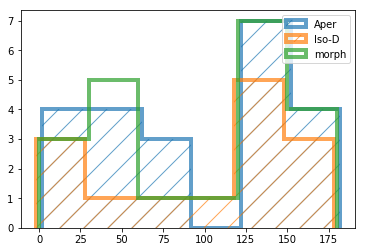

In [52]:
plt.hist(d_angle_a1+2, bins=np.linspace(0,180,7)+2,histtype="step", hatch="/", lw=4, alpha=0.7,label='Aper')
plt.hist(d_angle_d1-2, bins=np.linspace(0,180,7)-2,histtype="step",hatch="/", lw=4, alpha=0.7,label='Iso-D')
plt.hist(d_angle_dm1, bins=np.linspace(0,180,7),histtype="step", lw=4, hatch="", alpha=0.7,label='morph')
plt.legend()

(array([2., 1., 1., 1., 3., 2.]),
 array([  0.,  30.,  60.,  90., 120., 150., 180.]),
 <a list of 1 Patch objects>)

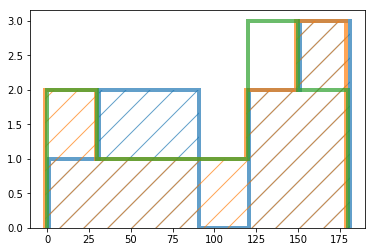

In [53]:
plt.hist(dA_a1+1, bins=np.linspace(0,180,7)+1,histtype="step", hatch="/", lw=4, alpha=0.7,label='Aper')
plt.hist(dA_d1-1, bins=np.linspace(0,180,7)-1,histtype="step", hatch="/", lw=4, alpha=0.7,label='Iso-D')
plt.hist(dA_dm1, bins=np.linspace(0,180,7),histtype="step",lw=4, hatch="", alpha=0.7,label='morph')

<ErrorbarContainer object of 3 artists>

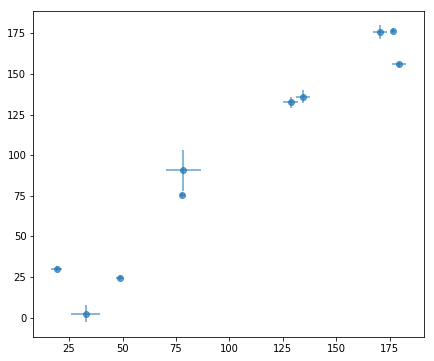

In [54]:
plt.figure(figsize=(7,6))
plt.errorbar(dA_a1, dA_d1, xerr=dA_std_a1, yerr=dA_std_d1, fmt="o", alpha=0.7)

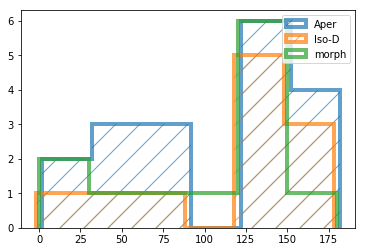

In [56]:
plt.hist(d_angle_a1+2, bins=np.linspace(0,180,7)+2,histtype="step", hatch="/", lw=4, alpha=0.7,label='Aper')
plt.hist(d_angle_d1-2, bins=np.linspace(0,180,7)-2,histtype="step",hatch="/", lw=4, alpha=0.7,label='Iso-D')
plt.hist(d_angle_dm1, bins=np.linspace(0,180,7),histtype="step", lw=4, hatch="", alpha=0.7,label='morph')
plt.legend()